In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

In [27]:

class GaussianModeRayFamily:
    def __init__(self, mode_type='LG', N=2, mu=2, w0=1.0, k=1.0):
        """
        Initialize a Gaussian mode ray family.
        
        Parameters:
        - mode_type: 'LG', 'HG', or 'GG'
        - N: mode order
        - mu: specific mode parameter (e.g., angular momentum for LG)
        - w0: beam waist width
        - k: wavenumber
        """
        self.mode_type = mode_type
        self.N = N
        self.mu = mu
        self.w0 = w0
        self.k = k
        
        # Parameters for GG mode (only used if mode_type is 'GG')
        self.theta = np.pi/4  # Default angle on Poincaré sphere
        self.phi = 0.0        # Default azimuth on Poincaré sphere

    def solif_angle(self, l):
        if abs(l) > self.N:
            return ValueError(f"l = {l} is greater than N = {self.N}")
        
        Omega = 2*np.pi*(self.N + 1 -l)/(self.N+1)
        return Omega
        
    def set_gg_parameters(self, theta, phi):
        """Set the direction parameters for a GG mode."""
        self.theta = theta
        self.phi = phi
    
    def generate_ray_family(self, num_eta=50, num_tau=50):
        """
        Generate a family of rays representing the Gaussian mode.
        
        Parameters:
        - num_eta: number of points along the Poincaré curve
        - num_tau: number of points around each ellipse
        
        Returns:
        - Dictionary containing ray positions, momenta, and Poincaré path
        """
        # Initialize arrays
        ray_positions = np.zeros((num_eta, num_tau, 2))  # (x,y) positions
        ray_momenta = np.zeros((num_eta, num_tau, 2))   # (px,py) momenta
        poincare_points = np.zeros((num_eta, 3))        # (s1,s2,s3) Stokes params
        
        # Parameter arrays
        eta_values = np.linspace(0, 2*np.pi, num_eta)
        phi_of_eta_values = np.zeros_like(eta_values)
        vartheta_of_eta_values = np.zeros_like(eta_values)
        tau_values = np.linspace(0, 2*np.pi, num_tau)
        
        # Define the Poincaré curve based on mode_type
        if self.mode_type == 'LG':
            # For LG: circle around vertical (s3) axis at latitude determined by mu/(N+1)
            latitude = np.arccos(self.mu/(self.N+1))  # θ = arccos(μ/(N+1))
            
            for i, eta in enumerate(eta_values):
                phi = eta  # Azimuthal angle on Poincaré sphere
                phi_of_eta_values[i] = phi
                vartheta_of_eta_values[i] = np.arcsin(self.mu/(self.N+1))
                poincare_points[i] = [
                    np.sin(latitude) * np.cos(phi),  # s1
                    np.sin(latitude) * np.sin(phi),  # s2
                    np.cos(latitude)                # s3
                ]
                
        elif self.mode_type == 'HG':
            # For HG: circle around horizontal (s1) axis at latitude determined by mu/(N+1)
            latitude = np.arccos(self.mu/(self.N+1))
            
            for i, eta in enumerate(eta_values):
                phi = eta  # Azimuthal angle on Poincaré sphere
                phi_of_eta_values[i] = phi
                vartheta_of_eta_values[i] = np.arcsin(self.mu/(self.N+1))
                
                poincare_points[i] = [
                    np.cos(latitude),                # s1
                    np.sin(latitude) * np.sin(eta),  # s2
                    np.sin(latitude) * np.cos(eta)   # s3
                ]
                
        elif self.mode_type == 'GG':
            # For GG: circle centered at (θ,φ) with radius determined by mu/(N+1)
            # The circle is on a plane perpendicular to the direction (θ,φ)
            center_direction = np.array([
                np.sin(self.theta) * np.cos(self.phi),
                np.sin(self.theta) * np.sin(self.phi),
                np.cos(self.theta)
            ])
            
            # Create two orthogonal unit vectors in the plane perpendicular to center_direction
            if np.abs(center_direction[2]) < 0.9:
                v1 = np.array([0, 0, 1])
            else:
                v1 = np.array([1, 0, 0])
                
            v1 = v1 - np.dot(v1, center_direction) * center_direction
            v1 = v1 / np.linalg.norm(v1)
            v2 = np.cross(center_direction, v1)
            
            # Calculate the radius on the Poincaré sphere
            radius = np.arccos(self.mu/(self.N+1))
            
            for i, eta in enumerate(eta_values):
                # Point on the circle around center_direction
                point = (np.cos(radius) * center_direction + 
                         np.sin(radius) * np.cos(eta) * v1 + 
                         np.sin(radius) * np.sin(eta) * v2)
                poincare_points[i] = point
        
        # Convert Poincaré points to ray parameters
        for i in range(num_eta):
            # Extract spherical coordinates from Poincaré point
            s1, s2, s3 = poincare_points[i]
            
            if self.mode_type == 'LG':
                phi = phi_of_eta_values[i]
                vartheta = vartheta_of_eta_values[i]

            else:
                # Convert to spherical coordinates
                phi = np.arctan2(s2, s1)
                theta = np.arccos(s3)
                
                # Convert to latitude angle (ϑ = π/2 - θ)
                vartheta = np.pi/2 - theta
                
            
            
            # Create rays for each point on the elliptic orbit
            for j, tau in enumerate(tau_values):
                # Create Jones vector components as in Eq. 3.4
                c = np.cos(vartheta/2)  # cos(ϑ/2)
                s = np.sin(vartheta/2)  # sin(ϑ/2)
                
                # vx = c * np.cos(phi/2) + 1j * s * np.sin(phi/2)
                # vy = s * np.cos(phi/2) - 1j * c * np.sin(phi/2)

                vx = c * np.cos(phi/2) - 1j * s * np.sin(phi/2)
                vy = c * np.sin(phi/2) + 1j * s * np.cos(phi/2)
                
                # Calculate Q and P from Jones vector using Eq. 3.5
                v = np.array([vx, vy])
                e_minus_i_tau = np.exp(-1j * tau)

                # Convert to physical position and momentum (Eq. 3.3)
                #2d version

                Q = np.real(v * e_minus_i_tau)
                P = np.imag(v * e_minus_i_tau)

                ray_positions[i,j,:] = self.w0 * np.sqrt(self.N+1) * Q
                ray_momenta[i,j,:] = (2*np.sqrt(self.N+1)/(self.k*self.w0)) * P
                
                # Q = np.real(vx * e_minus_i_tau)
                # P = np.imag(vx * e_minus_i_tau)
                
                # # Convert to physical position and momentum (Eq. 3.3)
                # ray_positions[i,j,0] = self.w0 * np.sqrt(self.N+1) * Q
                # ray_momenta[i,j,0] = (2*np.sqrt(self.N+1)/(self.k*self.w0)) * P
                
                # # Repeat for y-component
                # Q = np.real(vy * e_minus_i_tau)
                # P = np.imag(vy * e_minus_i_tau)
                
                # ray_positions[i,j,1] = self.w0 * np.sqrt(self.N+1) * Q
                # ray_momenta[i,j,1] = (2*np.sqrt(self.N+1)/(self.k*self.w0)) * P
        
        return {
            'positions': ray_positions,
            'momenta': ray_momenta,
            'poincare_points': poincare_points,
            'eta_values': eta_values,
            'tau_values': tau_values,
            'phi_of_eta_values': phi_of_eta_values,
            'vartheta_of_eta_values': vartheta_of_eta_values
        }
    
    def calculate_ROPL(self, ray_family):
        """
        Calculate the Reduced Optical Path Length for each ray.
        
        Parameters:
        - ray_family: output from generate_ray_family
        
        Returns:
        - S: array of ROPL values for each ray
        """
        poincare_points = ray_family['poincare_points']
        eta_values = ray_family['eta_values']
        tau_values = ray_family['tau_values']
        phi_of_eta_values = ray_family['phi_of_eta_values']
        vartheta_of_eta_values = ray_family['vartheta_of_eta_values']
        
        num_eta = len(eta_values)
        num_tau = len(tau_values)
        S = np.zeros((num_eta, num_tau))
        
        # Calculate the geometric phase Γ(η) - Equation 4.5
        Gamma = np.zeros(num_eta)
        
        for i in range(1, num_eta):
            # Extract parameters from Poincaré points
            s1_prev, s2_prev, s3_prev = poincare_points[i-1]
            s1_curr, s2_curr, s3_curr = poincare_points[i]
            
            # Convert to spherical coordinates
            # phi_prev = np.arctan2(s2_prev, s1_prev)
            # phi_curr = np.arctan2(s2_curr, s1_curr)
            # theta_prev = np.arccos(s3_prev)
            # theta_curr = np.arccos(s3_curr)
            phi_prev = phi_of_eta_values[i-1]
            phi_curr = phi_of_eta_values[i]
            theta_prev = vartheta_of_eta_values[i-1]
            theta_curr = vartheta_of_eta_values[i]


            
            # Handle 2π jumps in phi
            if phi_curr - phi_prev > np.pi:
                phi_curr -= 2*np.pi
            elif phi_curr - phi_prev < -np.pi:
                phi_curr += 2*np.pi
            
            # Geometric phase increment (Eq. 4.5)
            d_eta = eta_values[i] - eta_values[i-1]
            
            # Average value over the interval
            sin_theta = 0.5 * (np.sin(theta_prev) + np.sin(theta_curr))
            d_phi = (phi_curr - phi_prev) #/ d_eta
            
            Gamma[i] = Gamma[i-1] + 0.5 * sin_theta * d_phi #* d_eta
        
        # Calculate S for each ray (Eq. 4.7)
        for i in range(num_eta):
            # theta = np.arccos(poincare_points[i,2])
            # vartheta = np.pi/2 - theta  # Latitude angle
            vartheta = vartheta_of_eta_values[i]
            
            for j, tau in enumerate(tau_values):
                # S₁,η(τ) component (Eq. 4.3)
                S1 = (self.N+1) * (tau - 0.5 * np.cos(vartheta) * np.sin(2*tau))
                
                # S₂(η) component (Eq. 4.6)
                S2 = (self.N+1) * Gamma[i]
                
                # Total ROPL (Eq. 4.7)
                S[i,j] = S1 + S2
        
        return S, S1, S2, Gamma
    
    def visualize_poincare_sphere(self, ray_family, ax=None):
        """
        Visualize the Poincaré sphere with the path representing the mode.
        
        Parameters:
        - ray_family: output from generate_ray_family
        - ax: Optional matplotlib 3D axis to plot on
        """
        poincare_points = ray_family['poincare_points']
        
        if ax is None:
            fig = plt.figure(figsize=(8, 8))
            ax = fig.add_subplot(111, projection='3d')
        
        # Draw the Poincaré sphere
        u = np.linspace(0, 2 * np.pi, 30)
        v = np.linspace(0, np.pi, 30)
        x = np.outer(np.cos(u), np.sin(v))
        y = np.outer(np.sin(u), np.sin(v))
        z = np.outer(np.ones(np.size(u)), np.cos(v))
        
        ax.plot_surface(x, y, z, color='lightblue', alpha=0.3)
        
        # Draw coordinate axes
        ax.plot([-1.5, 1.5], [0, 0], [0, 0], 'k-', linewidth=1)
        ax.plot([0, 0], [-1.5, 1.5], [0, 0], 'k-', linewidth=1)
        ax.plot([0, 0], [0, 0], [-1.5, 1.5], 'k-', linewidth=1)
        
        # Label axes
        ax.text(1.6, 0, 0, '$s_1$')
        ax.text(0, 1.6, 0, '$s_2$')
        ax.text(0, 0, 1.6, '$s_3$')
        
        # Plot the equator
        phi_eq = np.linspace(0, 2*np.pi, 100)
        ax.plot(np.cos(phi_eq), np.sin(phi_eq), np.zeros_like(phi_eq), 'k-', linewidth=1, alpha=0.5)
        
        # Plot the Poincaré path with color gradient
        num_eta = len(poincare_points)
        colors = cm.jet(np.linspace(0, 1, num_eta))
        
        for i in range(num_eta-1):
            ax.plot(
                [poincare_points[i,0], poincare_points[i+1,0]],
                [poincare_points[i,1], poincare_points[i+1,1]],
                [poincare_points[i,2], poincare_points[i+1,2]],
                color=colors[i], linewidth=2
            )
        
        # Connect the last point to the first
        ax.plot(
            [poincare_points[-1,0], poincare_points[0,0]],
            [poincare_points[-1,1], poincare_points[0,1]],
            [poincare_points[-1,2], poincare_points[0,2]],
            color=colors[-1], linewidth=2
        )
        
        # Set equal aspect ratio
        ax.set_box_aspect([1, 1, 1])
        ax.set_xlim(-1.2, 1.2)
        ax.set_ylim(-1.2, 1.2)
        ax.set_zlim(-1.2, 1.2)
        
        # Remove ticks and labels
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_zticks([])
        
        return ax
    
    def visualize_ray_family(self, ray_family, ax=None, arrow_length=0.0):
        """
        Visualize the ray family in real space, colored by eta.
        
        Parameters:
        - ray_family: output from generate_ray_family
        - ax: Optional matplotlib axis to plot on
        """
        positions = ray_family['positions']
        momenta = ray_family['momenta']
        
        num_eta, num_tau = positions.shape[0:2]
        
        if ax is None:
            fig = plt.figure(figsize=(10, 10))
            ax = fig.add_subplot(111)
        
        # Draw the ray family with color gradient by eta
        colors = cm.hsv(np.linspace(0, 1, num_eta))
        
        if arrow_length >0:
            for i in range(num_eta):
                for j in range(num_tau):
                    # Get the ray position and momentum
                    pos = positions[i,j]
                    mom = momenta[i,j]
                    
                    # Plot the ray as an arrow
                    ax.arrow(
                        pos[0], pos[1],
                        mom[0], mom[1],
                        head_width=0.05, head_length=0.1,
                        fc=colors[i], ec=colors[i],
                        alpha=0.7
                    )
        else:
            for i in range(num_eta):
                ax.scatter(positions[i,:,0], positions[i,:,1], color=colors[i], alpha=0.7)
                ax.plot(positions[i,:,0], positions[i,:,1], c=colors[i], alpha=0.7)
            
        
        # Set equal aspect ratio
        ax.set_aspect('equal')
        
        # Add axis labels
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        
        # Add grid
        ax.grid(True, alpha=0.3)
        
        return ax
    
    def visualize_ray_family_tau(self, ray_family, ax=None):
        """
        Improved visualization of the ray family in real space with colors by eta.
        
        Parameters:
        - ray_family: output from generate_ray_family
        - ax: Optional matplotlib axis to plot on
        """
        positions = ray_family['positions']
        momenta = ray_family['momenta']
        
        num_eta, num_tau = positions.shape[0:2]
        
        if ax is None:
            fig = plt.figure(figsize=(10, 10))
            ax = fig.add_subplot(111)
        
        # Draw the ray positions as ellipses (orbits)
        for i in range(num_eta):
            # Create color gradient around each orbit
            orbit_colors = cm.hsv(np.linspace(0, 1, num_tau))
            
            # Extract x and y positions for this orbit
            x = positions[i,:,0]
            y = positions[i,:,1]
            
            # Draw rays as line segments from each position in the direction of momentum
            for j in range(num_tau):
                # Scale factor for arrow length
                scale = 0.3
                
                # Draw the ray
                ax.arrow(
                    x[j], y[j],
                    scale * momenta[i,j,0], scale * momenta[i,j,1],
                    head_width=0.05, head_length=0.05,
                    color=orbit_colors[j], alpha=0.7
                )
        
        # Set equal aspect ratio
        ax.set_aspect('equal')
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.grid(True, alpha=0.3)
        
        return ax
    
    def visualize_all(self, fig=None):
        """
        Generate and visualize a complete set of ray family information.
        
        Returns:
        - fig: matplotlib figure containing the visualizations
        """
        if fig is None:
            fig = plt.figure(figsize=(18, 8))
        
        # Generate ray family
        ray_family = self.generate_ray_family(num_eta=30, num_tau=20)
        
        # Calculate ROPL
        ropl = self.calculate_ROPL(ray_family)
        
        # Plot Poincaré sphere
        ax1 = fig.add_subplot(121, projection='3d')
        self.visualize_poincare_sphere(ray_family, ax=ax1)
        ax1.set_title(f'{self.mode_type}$_{{{self.N},{self.mu}}}$ Mode: Poincaré Sphere Path')
        
        # Plot ray family
        ax2 = fig.add_subplot(122)
        self.visualize_ray_family_better(ray_family, ax=ax2)
        ax2.set_title(f'{self.mode_type}$_{{{self.N},{self.mu}}}$ Mode: Ray Family')
        
        plt.tight_layout()
        return fig

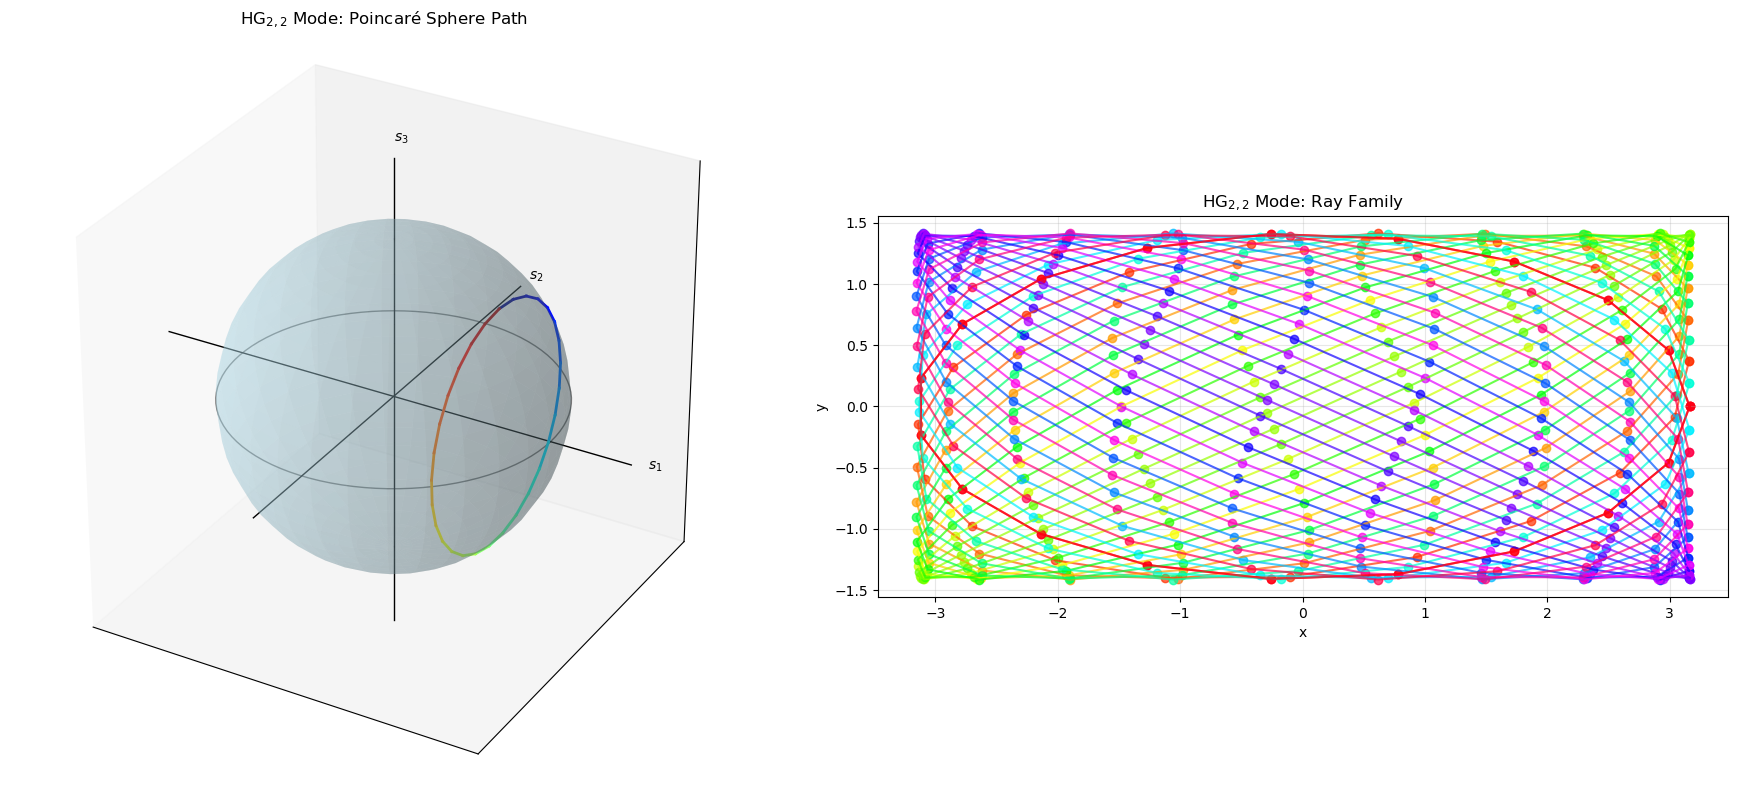

In [28]:
fig = plt.figure(figsize=(18, 8))

w = 2#10
k = 0.5# 2*np.pi/(780e-3)
# mode = GaussianModeRayFamily(mode_type='LG', N=3, mu=3, w0=w, k=k)
p=0
l=2
N = 2*p + abs(l)
# mode = GaussianModeRayFamily(mode_type='LG', N=N, mu=l, w0=w, k=k)
mode = GaussianModeRayFamily(mode_type='HG', N=N, mu=l, w0=w, k=k)

# Generate ray family
ray_family = mode.generate_ray_family(num_eta=30, num_tau=20)

# Calculate ROPL
ropl = mode.calculate_ROPL(ray_family)

# Plot Poincaré sphere
ax1 = fig.add_subplot(121, projection='3d')
mode.visualize_poincare_sphere(ray_family, ax=ax1)
ax1.set_title(f'{mode.mode_type}$_{{{mode.N},{mode.mu}}}$ Mode: Poincaré Sphere Path')

# Plot ray family
ax2 = fig.add_subplot(122)
mode.visualize_ray_family(ray_family, ax=ax2, arrow_length=0.0)
ax2.set_title(f'{mode.mode_type}$_{{{mode.N},{mode.mu}}}$ Mode: Ray Family')

plt.tight_layout()

In [29]:
S, S1, S2, Gamma = mode.calculate_ROPL(ray_family)

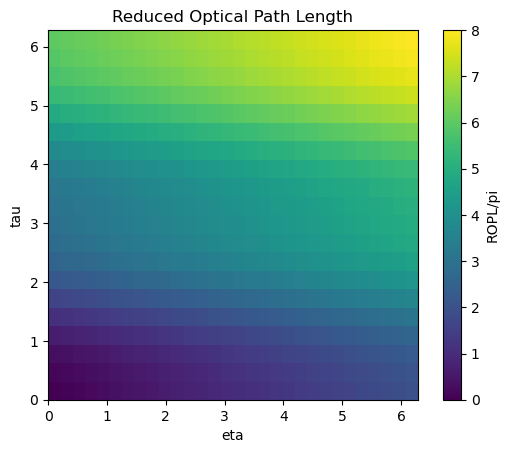

In [30]:
plt.figure()
# z in units of pi, also change colorbar to be in units of pi
plt.imshow((S.T/np.pi), extent=[0, 2*np.pi, 0, 2*np.pi], origin='lower')
plt.xlabel('eta')
plt.ylabel('tau')
plt.colorbar(label='ROPL/pi')
plt.title('Reduced Optical Path Length')
plt.show()

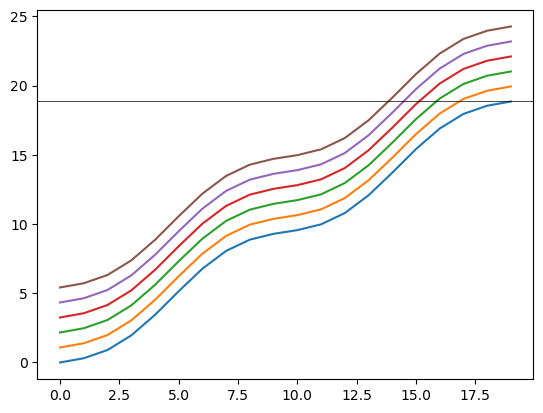

In [31]:
#S = np.zeros((num_eta, num_tau))
plt.figure()
for i in range(0, S.shape[0], 5):
    plt.plot(S[i,:]) # - S[i,0]
plt.axhline(y=2*np.pi*(mode.N+1), color='k', linewidth=0.5)
plt.show()


In [32]:
Omega = mode.solif_angle(mode.mu)

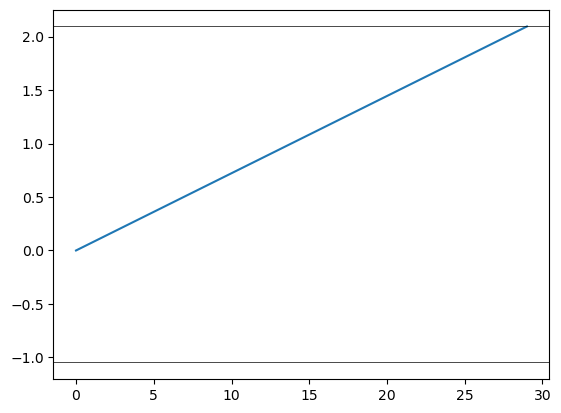

In [33]:
plt.figure()
plt.plot(Gamma)
plt.axhline(-0.5*Omega, color='k', linewidth=0.5)
plt.axhline(0.5*(2*np.pi-Omega), color='k', linewidth=0.5)
plt.show()

In [34]:
class GaussianFieldReconstructor:
    def __init__(self, gaussian_ray_family):
        """
        Initialize the field reconstructor with a GaussianModeRayFamily instance.
        """
        self.ray_family = gaussian_ray_family
    
    def fundamental_gaussian(self, r_grid, q, p):
        """
        Create a fundamental Gaussian beam centered at q with direction p.
        """
        # Calculate distance from center
        dx = r_grid[:, :, 0] - q[0]
        dy = r_grid[:, :, 1] - q[1]
        r_squared = dx**2 + dy**2
        
        # Phase from the ray direction
        phase = self.ray_family.k * (dx * p[0] + dy * p[1])
        
        # Gaussian amplitude
        amplitude = 1/(self.ray_family.w0 * np.sqrt(np.pi)) * np.exp(-r_squared / self.ray_family.w0**2)
        
        return amplitude * np.exp(1j * phase)
    
    def reconstruct_field(self, ray_family=None, grid_size=200, grid_extent=(-5, 5, -5, 5)):
        """
        Reconstruct the field using the SAFE method (Gaussian-dressed rays).
        """
        # Generate ray family if not provided
        if ray_family is None:
            ray_family = self.ray_family.generate_ray_family(num_eta=50, num_tau=40)
        
        # Calculate ROPL
        ropl, _, _, _ = self.ray_family.calculate_ROPL(ray_family)
        
        # Create evaluation grid
        x = np.linspace(grid_extent[0], grid_extent[1], grid_size)
        y = np.linspace(grid_extent[2], grid_extent[3], grid_size)
        x_grid, y_grid = np.meshgrid(x, y)
        r_grid = np.stack([x_grid, y_grid], axis=-1)
        
        # Initialize complex field
        field = np.zeros((grid_size, grid_size), dtype=complex)
        
        # Extract parameters
        positions = ray_family['positions']
        momenta = ray_family['momenta']
        # poincare_points = ray_family['poincare_points']
        eta_values = ray_family['eta_values']
        tau_values = ray_family['tau_values']
        phi_of_eta_values = ray_family['phi_of_eta_values']
        vartheta_of_eta_values = ray_family['vartheta_of_eta_values']

        
        num_eta = len(eta_values)
        num_tau = len(tau_values)
        d_eta = 2*np.pi / num_eta
        d_tau = 2*np.pi / num_tau
        
        print(f"Reconstructing field with {num_eta}×{num_tau} rays...")
        
        # Equation 6.6 - Integrate over all rays
        for i in range(num_eta):
            if i % 10 == 0:
                print(f"Processing ray family {i}/{num_eta}...")
                
            # Extract spherical coordinates from Poincaré point
            # s1, s2, s3 = poincare_points[i]
            
            # Convert to spherical coordinates
            # phi = np.arctan2(s2, s1)
            # theta = np.arccos(s3)
            phi = phi_of_eta_values[i]
            theta = vartheta_of_eta_values[i]
            
            # Calculate Jacobian factor (Eq. 6.2)
            if i < num_eta - 1:
                # phi_next = np.arctan2(poincare_points[i+1,1], poincare_points[i+1,0])
                # theta_next = np.arccos(poincare_points[i+1,2])
                phi_next = phi_of_eta_values[i+1]
                theta_next = vartheta_of_eta_values[i+1]
            else:
                # phi_next = np.arctan2(poincare_points[0,1], poincare_points[0,0])
                # theta_next = np.arccos(poincare_points[0,2])
                phi_next = phi_of_eta_values[0]
                theta_next = vartheta_of_eta_values[0]
                
            # Handle 2π jumps in phi
            if phi_next - phi > np.pi:
                phi_next -= 2*np.pi
            elif phi_next - phi < -np.pi:
                phi_next += 2*np.pi
                
            # Derivatives
            dphi_deta = (phi_next - phi) / d_eta
            dtheta_deta = (theta_next - theta) / d_eta
            
            # Jacobian square root term (Eq. 6.2)
            jacobian_factor = np.sqrt(0.5j * (dphi_deta * np.cos(theta) + 1j * dtheta_deta)) 
            # jacobian_factor = 1.0
            
            for j in range(num_tau):
                # Get ray position and momentum
                q = positions[i,j]
                p = momenta[i,j]
                

                tau = tau_values[j]
                # Phase factor from ROPL
                phase_factor = np.exp(1j * ropl[i,j] - 1j*tau)
                
                # Create Gaussian beam for this ray
                gaussian = self.fundamental_gaussian(r_grid, q, p)
                
                # Add contribution to the field
                field += jacobian_factor * phase_factor * gaussian * d_eta * d_tau
                
        return field, x_grid, y_grid
    
    def visualize_field(self, field, x_grid, y_grid, ax=None, plot_type='intensity'):
        """
        Visualize the reconstructed field.
        """
        if ax is None:
            fig = plt.figure(figsize=(10, 8))
            ax = fig.add_subplot(111)
            
        if plot_type == 'intensity':
            # Plot intensity |ψ|²
            intensity = np.abs(field)**2
            intensity_normalized = intensity / np.max(intensity)
            
            im = ax.pcolormesh(x_grid, y_grid, intensity_normalized, shading='auto', cmap='viridis')
            plt.colorbar(im, ax=ax, label='Normalized Intensity')
            ax.set_title('Field Intensity')
            
        elif plot_type == 'phase':
            # Plot phase arg(ψ)
            phase = np.angle(field)
            mask = np.abs(field)**2 < 0.01 * np.max(np.abs(field)**2)  # Mask low intensity regions
            masked_phase = np.ma.masked_where(mask, phase)
            
            im = ax.pcolormesh(x_grid, y_grid, masked_phase, shading='auto', cmap='hsv', 
                              vmin=-np.pi, vmax=np.pi)
            plt.colorbar(im, ax=ax, label='Phase (rad)')
            ax.set_title('Field Phase')
            
        elif plot_type == 'real_part':
            # Plot real part Re(ψ)
            real_part = np.real(field)
            
            im = ax.pcolormesh(x_grid, y_grid, real_part, shading='auto', cmap='RdBu_r')
            plt.colorbar(im, ax=ax, label='Re(ψ)')
            ax.set_title('Field Real Part')
            
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_aspect('equal')
        
        return ax
    
    def visualize_all(self, ray_family=None, field=None, grid_size=200, grid_extent=(-5, 5, -5, 5)):
        """
        Complete pipeline to generate, reconstruct, and visualize a field.
        """
        # Generate ray family if not provided
        if ray_family is None:
            ray_family = self.ray_family.generate_ray_family(num_eta=50, num_tau=40)
            
        # Reconstruct field if not provided
        if field is None:
            field, x_grid, y_grid = self.reconstruct_field(ray_family, grid_size, grid_extent)
        else:
            x = np.linspace(grid_extent[0], grid_extent[1], grid_size)
            y = np.linspace(grid_extent[2], grid_extent[3], grid_size)
            x_grid, y_grid = np.meshgrid(x, y)
        
        # Create visualization figure
        fig = plt.figure(figsize=(18, 12))
        
        # Plot the Poincaré sphere
        ax1 = fig.add_subplot(231, projection='3d')
        self.ray_family.visualize_poincare_sphere(ray_family, ax=ax1)
        ax1.set_title(f'Poincaré Path: {self.ray_family.mode_type}$_{{{self.ray_family.N},{self.ray_family.mu}}}$')
        
        # Plot ray family (positions)
        ax2 = fig.add_subplot(232)
        self.ray_family.visualize_ray_family(ray_family, ax=ax2)
        ax2.set_title('Ray Positions')
        
        # Plot ray family with velocities
        ax3 = fig.add_subplot(233)
        self.ray_family.visualize_ray_family_tau(ray_family, ax=ax3)
        ax3.set_title('Ray Positions and Directions')
        
        # Plot field intensity
        ax4 = fig.add_subplot(234)
        self.visualize_field(field, x_grid, y_grid, ax=ax4, plot_type='intensity')
        
        # Plot field phase
        ax5 = fig.add_subplot(235)
        self.visualize_field(field, x_grid, y_grid, ax=ax5, plot_type='phase')
        
        # Plot field real part
        ax6 = fig.add_subplot(236)
        self.visualize_field(field, x_grid, y_grid, ax=ax6, plot_type='real_part')
        
        plt.tight_layout()
        mode_type = self.ray_family.mode_type
        N = self.ray_family.N
        mu = self.ray_family.mu
        fig.suptitle(f'{mode_type}$_{{{N},{mu}}}$ Mode Reconstruction', fontsize=16, y=0.99)
        
        return fig, field, x_grid, y_grid



In [35]:
from numba import njit, prange
import numpy as np

@njit(parallel=True)
def cache_optimized_field_reconstruction(positions, momenta, eta_values, tau_values, 
                                         phi_values, theta_values, ropl, 
                                         grid_extent, grid_size, sigma=1.0, k=1.0):
    # Create evaluation grid
    x = np.linspace(grid_extent[0], grid_extent[1], grid_size)
    y = np.linspace(grid_extent[2], grid_extent[3], grid_size)

    sigma_squared = sigma**2
    norm = 1/(sigma * np.sqrt(np.pi)) 
    
    # Initialize complex field
    field = np.zeros((grid_size, grid_size), dtype=np.complex128)
    
    num_eta = len(eta_values)
    num_tau = len(tau_values)
    d_eta = 2*np.pi / num_eta
    d_tau = 2*np.pi / num_tau
    
    # Calculate cutoff distance for Gaussian (beyond which contribution is negligible)
    # (e.g., 4*sigma means we capture ~99.994% of the Gaussian)
    cutoff_distance = 5.0 * sigma
    cutoff_squared = cutoff_distance * cutoff_distance
    
    # Calculate grid spacing
    dx = (grid_extent[1] - grid_extent[0]) / (grid_size - 1)
    dy = (grid_extent[3] - grid_extent[2]) / (grid_size - 1)
    
    # Pre-compute all jacobian factors (can be reused across tau values)
    jacobian_factors = np.zeros(num_eta, dtype=np.complex128)
    for i in range(num_eta):
        phi = phi_values[i]
        theta = theta_values[i]
        
        phi_next = phi_values[(i+1) % num_eta]
        theta_next = theta_values[(i+1) % num_eta]
        
        # Handle 2π jumps
        if phi_next - phi > np.pi:
            phi_next -= 2*np.pi
        elif phi_next - phi < -np.pi:
            phi_next += 2*np.pi
        
        # Derivatives & Jacobian
        dphi_deta = (phi_next - phi) / d_eta
        dtheta_deta = (theta_next - theta) / d_eta
        # jac_real = 0.5 * (-dphi_deta * np.cos(theta))
        # jac_imag = 0.5 * dtheta_deta
        # jacobian_factors[i] = np.sqrt(complex(jac_real, jac_imag))
        jacobian_factors[i] = np.sqrt(0.5j * (dphi_deta * np.cos(theta) + 1j * dtheta_deta)) 
    
    # Outer parallel loop over y-grid values (each thread handles a row)
    for y_idx in prange(grid_size):
        y_val = y[y_idx]
        
        # Process this row sequentially
        for x_idx in range(grid_size):
            x_val = x[x_idx]
            r = np.array([x_val, y_val])
            
            # Initialize accumulator for this grid point
            field_sum = 0.0j
            
            # Process rays in blocks for better cache utilization of ray data
            block_size = 32  # Adjust based on your specific problem
            for i_block in range(0, num_eta, block_size):
                i_end = min(i_block + block_size, num_eta)
                
                # Process each ray in the current block
                for i in range(i_block, i_end):
                    jacobian_factor = jacobian_factors[i]
                    
                    for j in range(num_tau):
                        # Get ray position
                        q = positions[i, j]
                        p = momenta[i, j]
                        
                        # Check if within cutoff distance
                        # dist_squared = (r[0] - q[0])**2 + (r[1] - q[1])**2
                        # Calculate distance from center
                        dx = r[0] - q[0]
                        dy = r[1] - q[1]
                        dist_squared = dx**2 + dy**2
                        
                        # Phase from the ray direction
                        phase = k * (dx * p[0] + dy * p[1])
                        
                        if dist_squared <= cutoff_squared:
                            # Phase factor from ROPL
                            tau = tau_values[j]
                            phase_factor = np.exp(1j * ( phase + ropl[i, j] -  tau))
                            
                            # Gaussian
                            gaussian = norm*np.exp(-dist_squared / (sigma_squared))
                            
                            # Add contribution
                            field_sum += jacobian_factor * phase_factor * gaussian * d_eta * d_tau
            
            # Store the accumulated value for this grid point
            field[y_idx, x_idx] = field_sum
    
    return field

Reconstructing field with 50×40 rays...
Processing ray family 0/50...
Processing ray family 10/50...
Processing ray family 20/50...
Processing ray family 30/50...
Processing ray family 40/50...


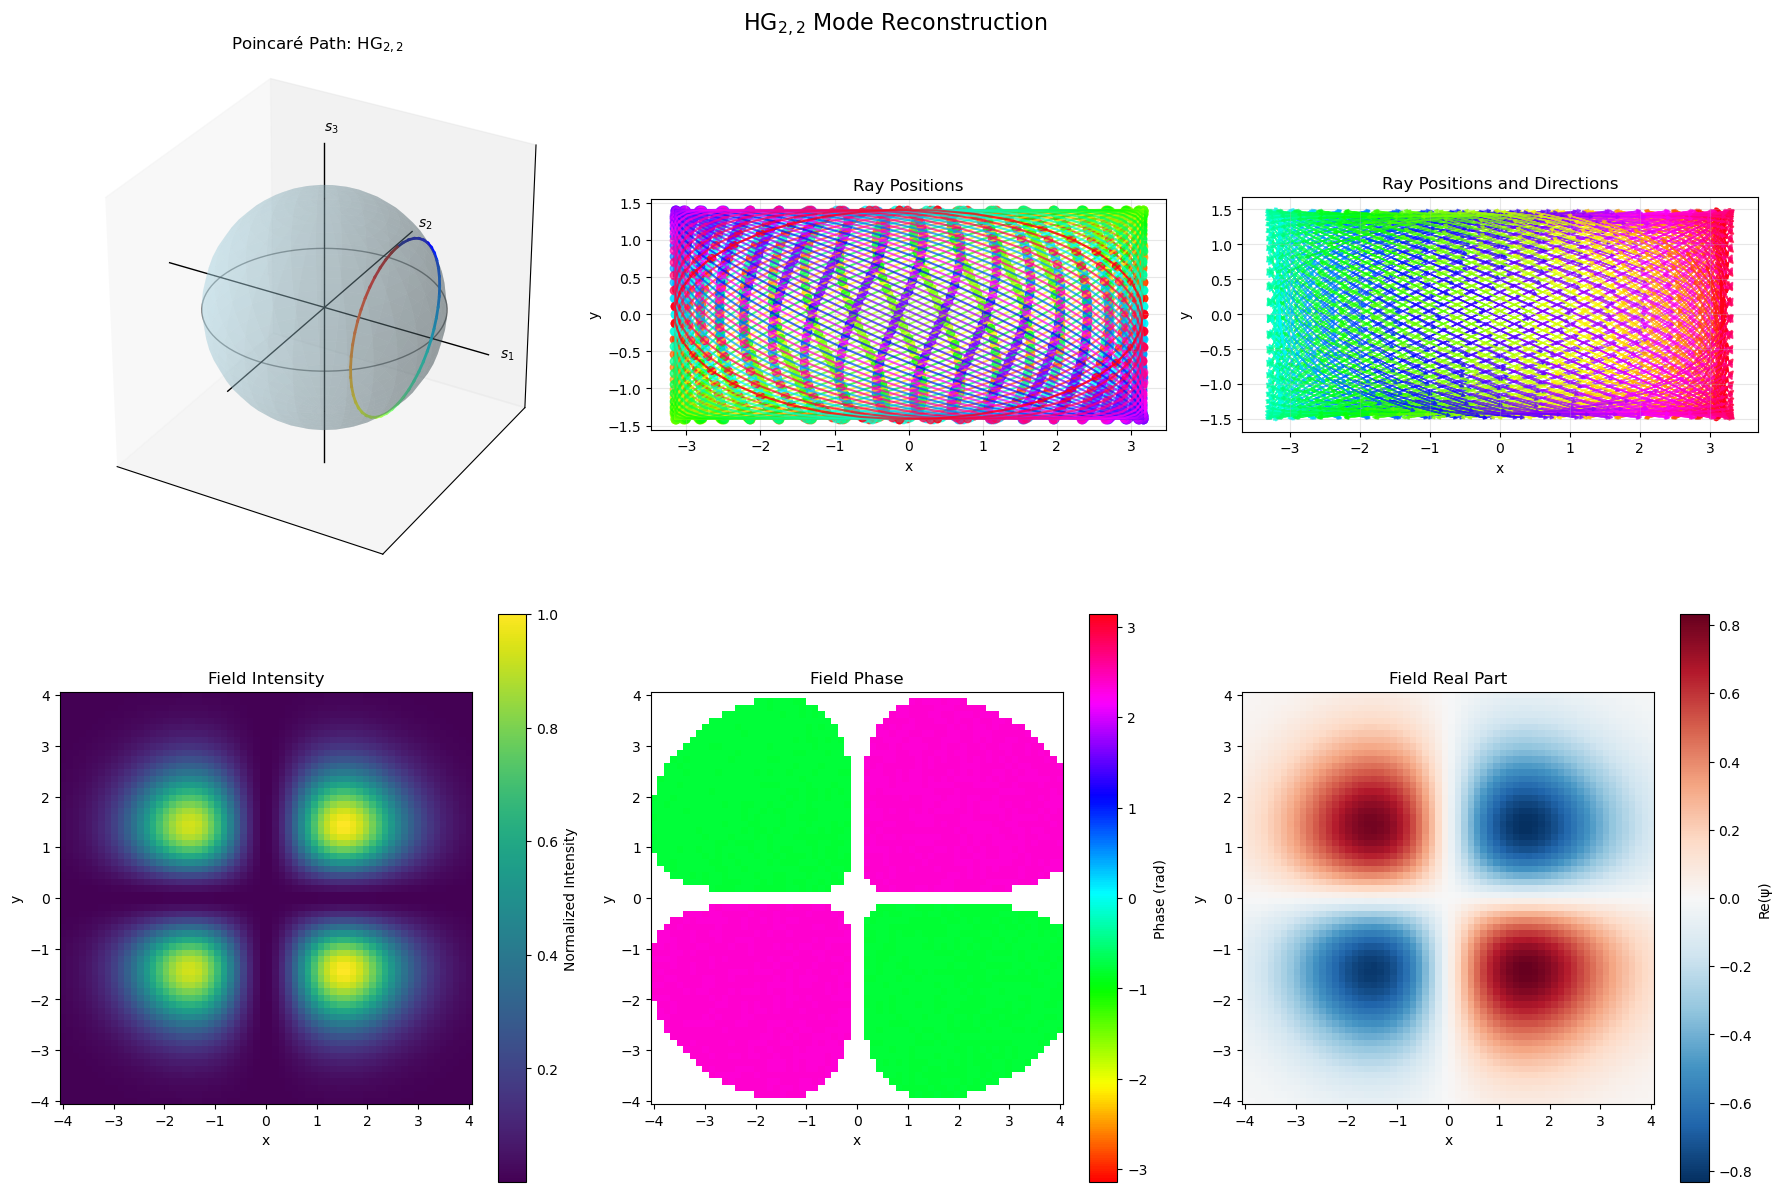

In [36]:

# Create reconstructor for the chosen mode
reconstructor = GaussianFieldReconstructor(mode)

# Full visualization
fig, field, x_grid, y_grid = reconstructor.visualize_all(grid_size=64, grid_extent=(-4, 4, -4, 4))

plt.show()

In [14]:
ray_family = mode.generate_ray_family(num_eta=40, num_tau=50)
# Extract parameters
ropl, _, _, _ = mode.calculate_ROPL(ray_family)

In [15]:

# %%timeit
field_nb = cache_optimized_field_reconstruction(positions = ray_family['positions'],
                                                momenta = ray_family['momenta'],
                                                eta_values = ray_family['eta_values'],
                                                tau_values = ray_family['tau_values'],
                                                phi_values = ray_family['phi_of_eta_values'],
                                                theta_values = ray_family['vartheta_of_eta_values'],
                                                ropl=ropl,
                                                grid_extent=[-5, 5, -5, 5],
                                                grid_size=128,
                                                k=mode.k,
                                                sigma=mode.w0
                                                )

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


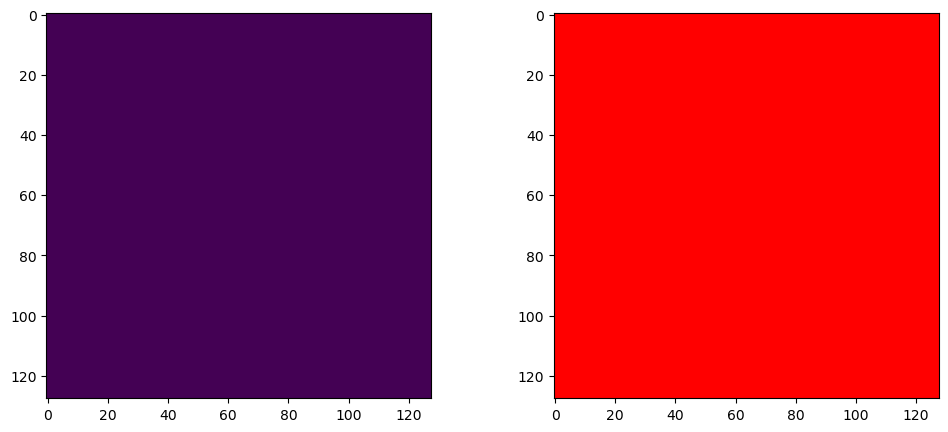

In [16]:
f, ax = plt.subplots(ncols=2, figsize=(12,5))

ax[0].imshow(np.abs(field_nb)**2, interpolation='bilinear')
ax[1].imshow(np.angle(field_nb), cmap='hsv')

In [154]:
%matplotlib widget
from ipywidgets import *
import numpy as np
import k3d

import matplotlib.pyplot as plt
from scipy.optimize import minimize_scalar
from sloppy.optic import *
from sloppy.raytracing import *
from sloppy.abcd import *
from sloppy.utils import *
from sloppy.tools import *

In [156]:
def source_MLA_bundle(Nx=2, Ny=None, Nsx=5, Nsy=None, dx=0.5, dy=None, sx=1e-3, sy=None, Nex=0, Ney=None, ex=0, ey=None):
    if Ny is None:
        Ny = Nx

    if Nsy is None:
        Nsy = Nsx

    if dy is None:
        dy = dx

    if sy is None:
        sy = sx

    if Ney is None:
        Ney = Nex

    if ey is None:
        ey = ex

    # make iterators for x and y displacements and slopes and little epsilon displacements around MLA positions
    it_x = np.linspace(-dx*Nx, dx*Nx, 2*Nx+1) if Nx>0 else np.array([0])
    it_y = np.linspace(-dy*Ny, dy*Ny, 2*Ny+1) if Ny>0 else np.array([0])
    it_sx = np.linspace(-sx*Nsx, sx*Nsx, 2*Nsx+1) if Nsx>0 else np.array([0])
    it_sy = np.linspace(-sy*Nsy, sy*Nsy, 2*Nsy+1) if Nsy>0 else np.array([0])
    it_ex = np.linspace(-ex*Nex, ex*Nex, 2*Nex+1) if Nex>0 else np.array([0])
    it_ey = np.linspace(-ey*Ney, ey*Ney, 2*Ney+1) if Ney>0 else np.array([0])

    # iterate over all combinations of the iterators using itertools.product and make a bundle id for every x and y location
    mus = np.stack([[x+ex, y+ey, sx, sy] for x in it_x for y in it_y for sx in it_sx for sy in it_sy for ex in it_ex for ey in it_ey], axis=0)
    bundle_ids = np.stack([[i, j] for i, x in enumerate(it_x) for j, y in enumerate(it_y) for k, sx in enumerate(it_sx) for l, sy in enumerate(it_sy) for m, ex in enumerate(it_ex) for n, ey in enumerate(it_ey)], axis=0)


    return mus, bundle_ids

In [191]:
def cav(f=50.0, thick=4.0, eps=3.0, offset=0.0):

    ng = 1.4537
    R = (ng-1)*f
    
    nz = (0., 0. ,-1.0)
    nzm = (0., 0. ,1.0)
    axz = (-1, 0, 0)
    axzm = (1, 0, 0)

    p_grin_f = f
    p_grin_b = p_grin_f + thick
    p_long_f = p_grin_b + f - eps

    p00 = np.array([0,0,0])
    p0 = np.array([offset,0,p_grin_f])
    p1 = np.array([0,0,p_grin_b])
    p2 = np.array([0,0,p_long_f])

    ii = 25.4

    elements = [Screen(p=p00, n=nz, ax=axz, diameter=25.4),
                CurvedGlass(p=p0, n=nzm, ax=axzm, diameter=ii, R=R, curv='CC', n2=ng),
                Glass(p=p1, n=nzm, ax=axzm, diameter=ii, n1=ng),
                Screen(p=p2, n=nzm, ax=axzm, diameter=25.4)]
    
    return elements

In [350]:
elements = cav(eps=5.0, offset=0.1)

screen = elements[0]
sys = RaySystem(elements, add_screen=False)
sys.screen = screen


mu, bundle_id = source_MLA_bundle(Nx=5, Ny=0, Nsx=0, Nsy=0, dx=0.1, sx=1e-3, Nex=0, ex=10e-3)


# make the (i,j) bundle id a 1d array by adding i+j*Nx for every i,j pair
Nx = len(np.unique(bundle_id[:,0]))
bundle_ids = bundle_id[:,0] + bundle_id[:,1]*Nx

N = len(np.unique(bundle_ids))
viridis = plt.cm.viridis

# Extract N evenly spaced colors from viridis
colors = viridis(np.linspace(0, 1, N))

ray = sys.screen.eigenvectors_to_rays(mu)
traj = sys.propagate(ray, at_screen=False, clip=True)

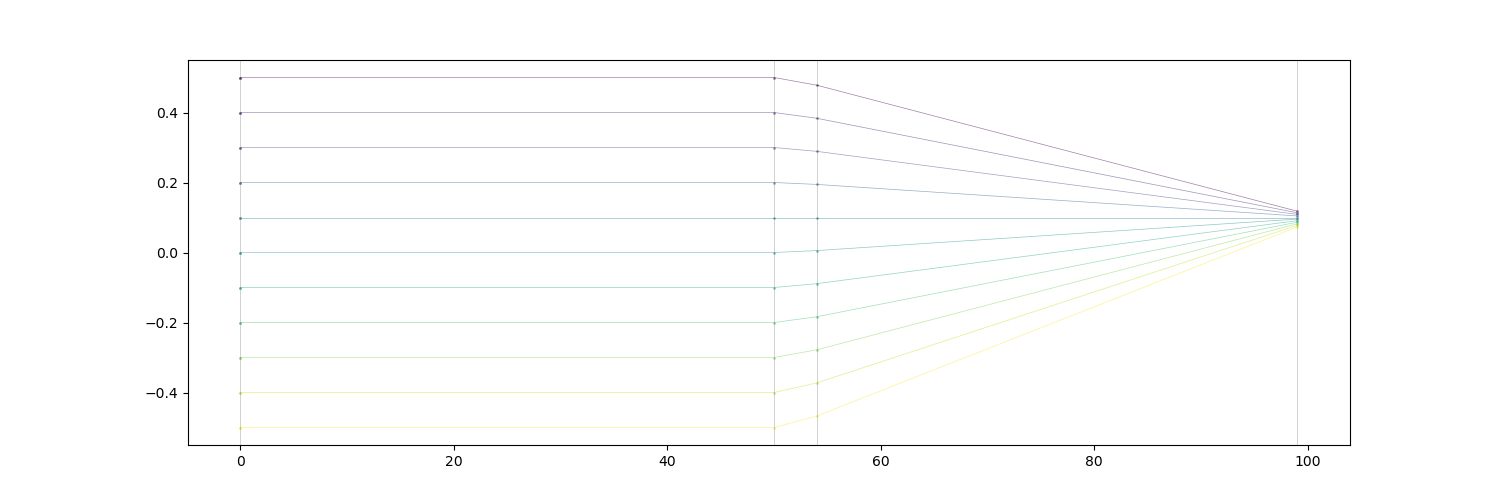

In [351]:
# make the plot
lines = []
fig, ax = plt.subplots(ncols=1, figsize=(15, 5))
plane = 'x'
k = 0 if plane == 'x' else 1
for i in range(traj.shape[2]):
    l = plt.plot(traj[:, 0, i, 2], traj[:, 0, i, k], color=colors[bundle_ids[i]], alpha=0.5, lw=0.5, marker='.', ms=2)[0]
    lines.append(l)

for el in elements:
    plt.axvline(el.p[2], color='grey', alpha=0.5, lw=0.5)
# plt.plot(traj_hit[:, 0, 0, 2], traj_hit[:, 0, 0, k], color='r', alpha=0.5, lw=0.5)[0]

In [352]:
traj.shape

(5, 2, 11, 3)

In [353]:
# measure the OPL
def opl_from_traj(traj):
    opls = traj[1:,0,:,:] - traj[:-1,0,:,:]
    return np.linalg.norm(opls, axis=-1)

In [354]:
opl = opl_from_traj(traj)

In [355]:
# we need to multiply the OPL by the index of refraction when it's in the glass
opl[1,:] *= 1.4537

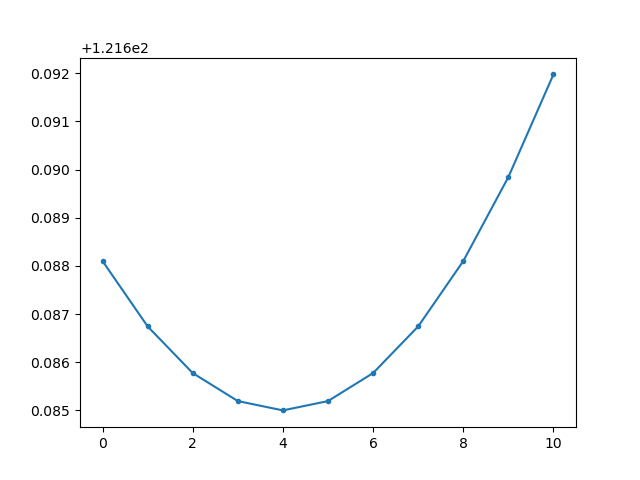

In [356]:
plt.figure()
plt.plot(np.sum(opl, axis=0), marker='.')
plt.show()

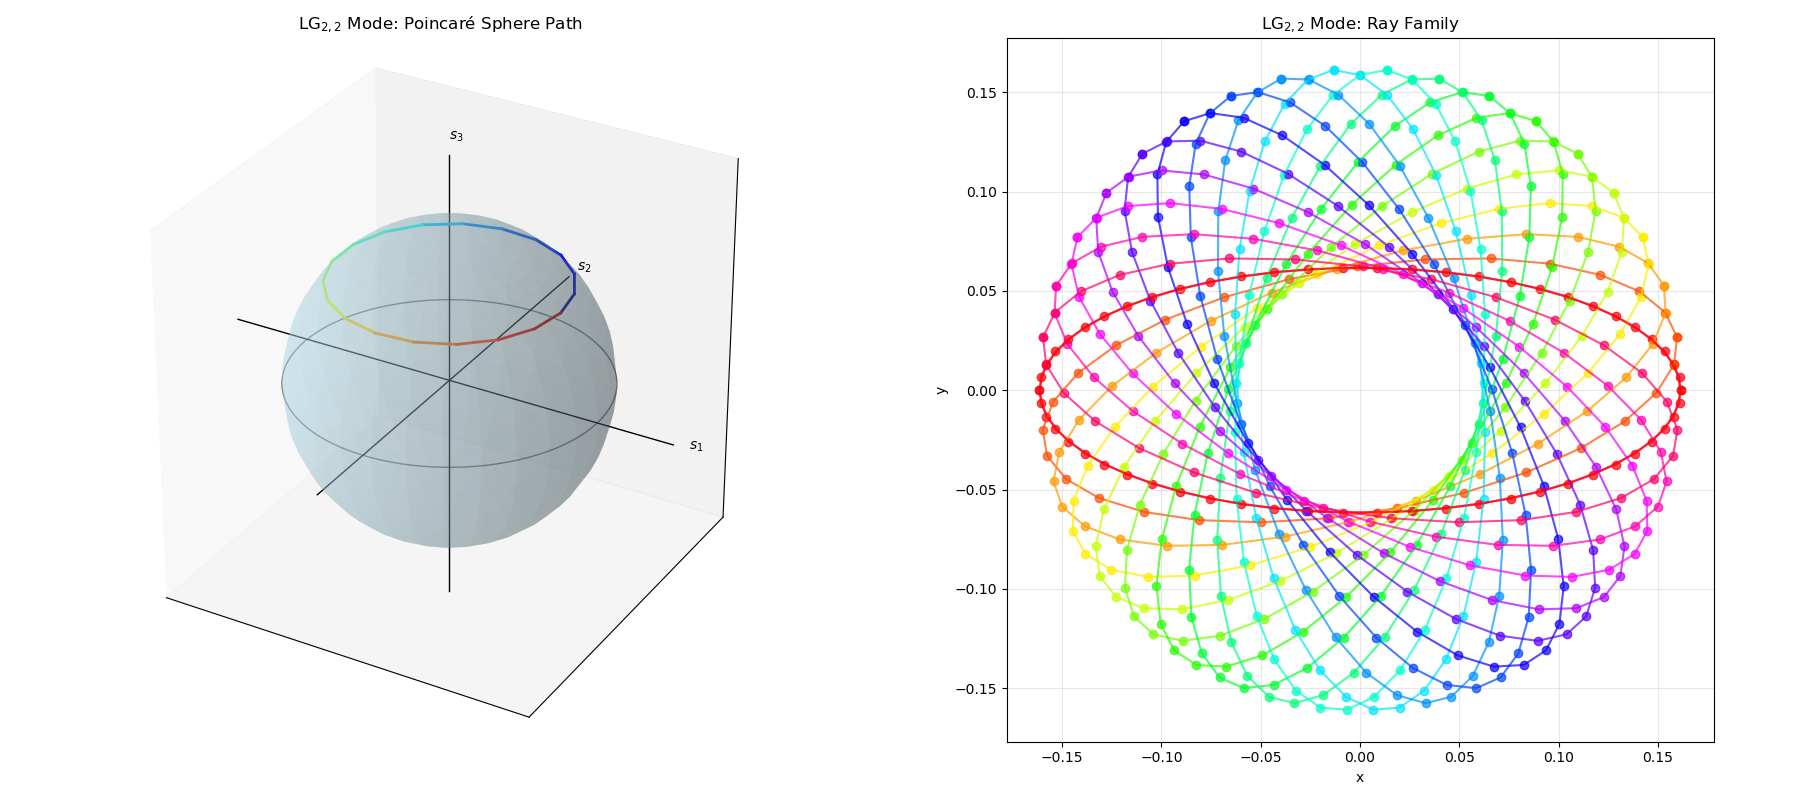

In [357]:
fig = plt.figure(figsize=(18, 8))

w = 0.1
k = 2*np.pi/(1e-3)

p=0
l=2
N = 2*p + abs(l)
mode = GaussianModeRayFamily(mode_type='LG', N=N, mu=l, w0=w, k=k)

# Generate ray family
ray_family = mode.generate_ray_family(num_eta=20, num_tau=30)

# Calculate ROPL
ropl, _, _, _ = mode.calculate_ROPL(ray_family)

# Plot Poincaré sphere
ax1 = fig.add_subplot(121, projection='3d')
mode.visualize_poincare_sphere(ray_family, ax=ax1)
ax1.set_title(f'{mode.mode_type}$_{{{mode.N},{mode.mu}}}$ Mode: Poincaré Sphere Path')

# Plot ray family
ax2 = fig.add_subplot(122)
mode.visualize_ray_family(ray_family, ax=ax2, arrow_length=0.0)
ax2.set_title(f'{mode.mode_type}$_{{{mode.N},{mode.mu}}}$ Mode: Ray Family')

plt.tight_layout()

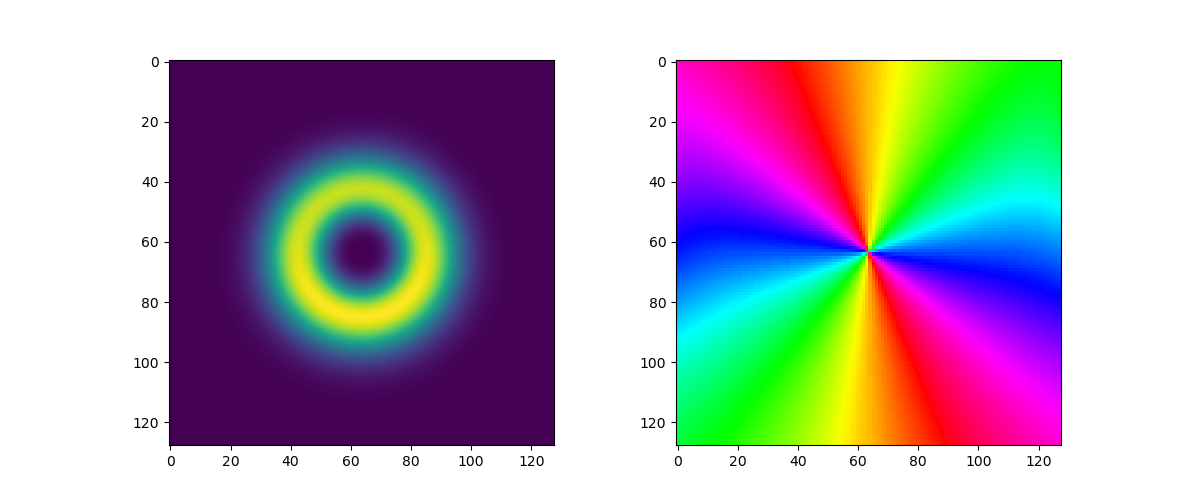

In [358]:

a = w*3.0
# %%timeit
field_nb = cache_optimized_field_reconstruction(positions = ray_family['positions'],
                                                momenta = ray_family['momenta'],
                                                eta_values = ray_family['eta_values'],
                                                tau_values = ray_family['tau_values'],
                                                phi_values = ray_family['phi_of_eta_values'],
                                                theta_values = ray_family['vartheta_of_eta_values'],
                                                ropl=ropl,
                                                grid_extent=[-a, a, -a, a],
                                                grid_size=128,
                                                k=mode.k,
                                                sigma=mode.w0
                                                )

f, ax = plt.subplots(ncols=2, figsize=(12,5))

ax[0].imshow(np.abs(field_nb)**2, interpolation='bilinear')
ax[1].imshow(np.angle(field_nb), cmap='hsv')

In [359]:
orig_shape = ray_family['positions'].shape
# stack positions and momenta into paraxial eigenvectors mu
# mu = np.array([1e-1, 0., 0., 1e-3])
mus = np.concatenate([ray_family['positions'].reshape((-1,2)), ray_family['momenta'].reshape((-1,2))], axis=-1)


In [360]:
ray = sys.screen.eigenvectors_to_rays(mus)
traj = sys.propagate(ray, at_screen=False, clip=True)

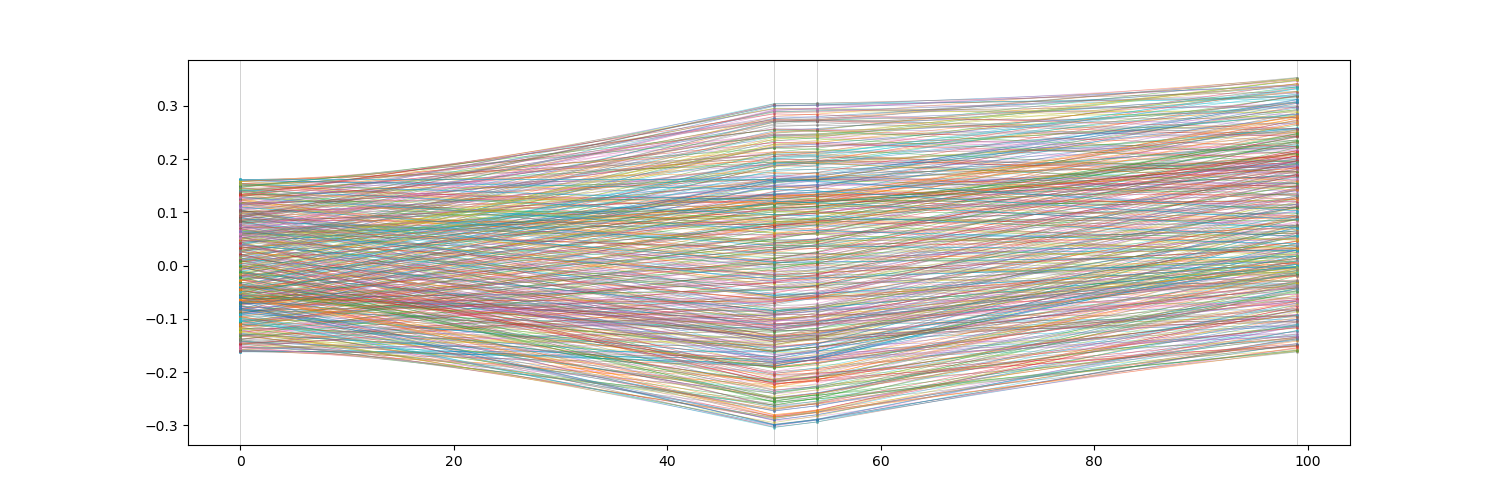

In [361]:
# make the plot
lines = []
fig, ax = plt.subplots(ncols=1, figsize=(15, 5))
plane = 'x'
k = 0 if plane == 'x' else 1
for i in range(traj.shape[2]):
    l = plt.plot(traj[:, 0, i, 2], traj[:, 0, i, k], alpha=0.5, lw=0.5, marker='.', ms=2)[0]
    lines.append(l)

for el in elements:
    plt.axvline(el.p[2], color='grey', alpha=0.5, lw=0.5)
# plt.plot(traj_hit[:, 0, 0, 2], traj_hit[:, 0, 0, k], color='r', alpha=0.5, lw=0.5)[0]

[]

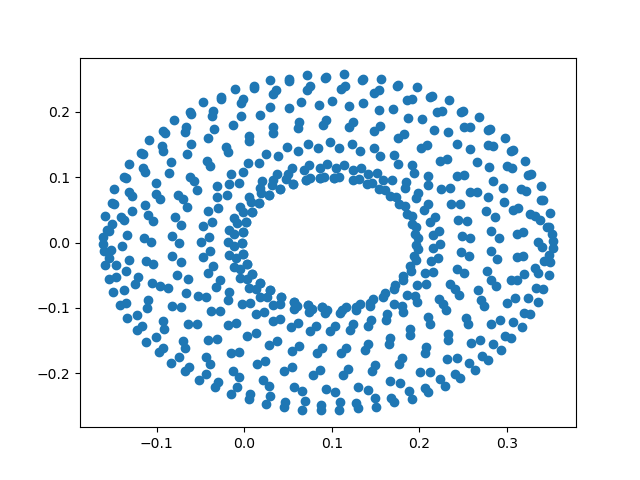

In [362]:
plt.figure()
el=4
plt.scatter(traj[el,0,:,0], traj[el,0,:,1])
plt.plot()

In [363]:
# turn rays back into eigenvectors
mus_out = sys.elements[el-1].rays_to_eigenvectors(traj[el,:,:,:])
mus_out.shape


(600, 4)

In [364]:
pos_out = mus_out[:,:2].reshape(orig_shape)
mom_out = mus_out[:,2:].reshape(orig_shape)

In [365]:
opl = opl_from_traj(traj)
opl[1,:] *= 1.4537
opl = np.sum(opl, axis=0)

In [366]:
ropl.shape

(20, 30)

In [367]:
# added action because of propagation
Stot = ropl + mode.k*opl.reshape(orig_shape[:-1])

In [368]:

# %%timeit
b = a*2  
field_nb = cache_optimized_field_reconstruction(positions = pos_out,
                                                momenta = mom_out,
                                                eta_values = ray_family['eta_values'],
                                                tau_values = ray_family['tau_values'],
                                                phi_values = ray_family['phi_of_eta_values'],
                                                theta_values = ray_family['vartheta_of_eta_values'],
                                                ropl=Stot,
                                                grid_extent=[-b, b, -b, b],
                                                grid_size=128,
                                                k=mode.k,
                                                sigma=mode.w0
                                                )

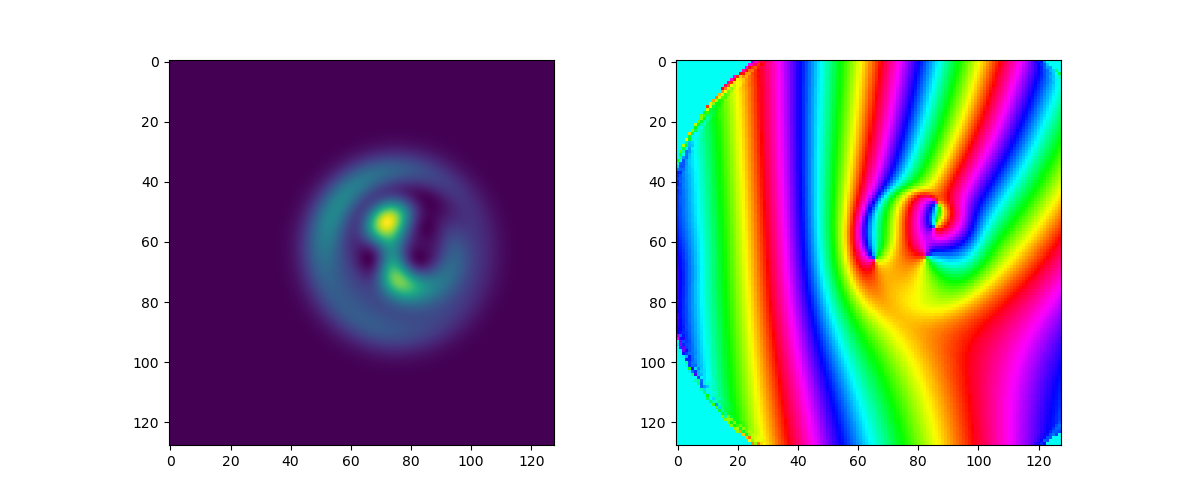

In [369]:
f, ax = plt.subplots(ncols=2, figsize=(12,5))

ax[0].imshow(np.abs(field_nb)**2, interpolation='bilinear')
ax[1].imshow(np.angle(field_nb), cmap='hsv')